<a href="https://colab.research.google.com/github/khodid/2020Evening/blob/master/proj3_2_VAE_MNIST_withLinearModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torchvision

MNIST_train = torchvision.datasets.MNIST(root = './content', train = True, transform = torchvision.transforms.ToTensor(), download = True)

Extracting ./content/MNIST/raw/train-images-idx3-ubyte.gz to ./content/MNIST/raw



Extracting ./content/MNIST/raw/train-labels-idx1-ubyte.gz to ./content/MNIST/raw


Extracting ./content/MNIST/raw/t10k-images-idx3-ubyte.gz to ./content/MNIST/raw


Extracting ./content/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./content/MNIST/raw
Processing...
Done!




/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [2]:
import torch.utils

In [3]:
# dataloader 설정
batch_size = 20

train_set = torch.utils.data.DataLoader(MNIST_train, batch_size= batch_size, shuffle = True, drop_last = True)

In [4]:
# 디바이스 설정
import torch.cuda
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda' : torch.cuda.manual_seed_all(777)

In [5]:
# Checking training data shape
print(type(train_set))
for img, label in train_set:
  break
print(img.shape)

<class 'torch.utils.data.dataloader.DataLoader'>
torch.Size([20, 1, 28, 28])


In [6]:
import torch.nn as nn

class VAE(nn.Module):
  def __init__(self, latent_size):
    super(VAE, self).__init__()
    self.latent_size = latent_size
    self.encoder = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 512),
        nn.Linear(512, 256)
        )
    self.mu = nn.Linear(256, self.latent_size)
    self.var = nn.Linear(256, self.latent_size)
    self.decoder = nn.Sequential(
        nn.Linear(self.latent_size, 256),
        nn.Linear(256, 512),
        nn.Linear(512, 784),
        nn.Sigmoid()
        )
      
  def sampler(self, mu, var):
    sigma = torch.exp(0.5*var)
    epsilon = torch.randn_like(sigma)
    return mu + epsilon*sigma

  def Encode(self, x):
    z = self.encoder(x)
    mu = self.mu(z)
    var = self.var(z)
    z = self.sampler(mu, var)
    return z, mu, var

  def Decode(self, z):
    img = self.decoder(z)
    img = img.view(z.size(0), 1, 28, 28)
    return img
  
  def forward(self, x):
    z, mu, var = self.Encode(x)
    img = self.Decode(z)
    return img, mu, var

====== ENCODER ======
torch.Size([64, 10])
====== DECODER ======
torch.Size([64, 1, 28, 28])


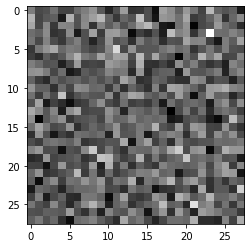

In [7]:
# model test
with torch.no_grad():
  input = torch.randn(64, 1, 28, 28).to(device)
  model = VAE(latent_size = 10).to(device)
  test_z, _, _ = model.Encode(input)
  test_out = model.Decode(test_z)

  print('====== ENCODER ======')
  print(test_z.shape)
  print('====== DECODER ======')
  print(test_out.shape)

  import matplotlib.pyplot as plt
  if device == 'cuda': test_out = test_out.cpu()
  show = test_out[0].view(28,28).numpy()
  plt.imshow(show, cmap='gray')

In [8]:
model = VAE(latent_size= 10).to(device)
model.train()

VAE(
  (encoder): Sequential(
    (0): Flatten()
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
  )
  (mu): Linear(in_features=256, out_features=10, bias=True)
  (var): Linear(in_features=256, out_features=10, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=784, bias=True)
    (3): Sigmoid()
  )
)

In [49]:
# 얘는 그냥 프로젝트 1에서 복붙함. loss function
import torch.nn.functional as F

def loss_function(x, target, mu, log_var):
  x, target = x.view(-1, 784), target.view(-1, 784) # (batch_size, 784)
  # rmse_loss = torch.sum(torch.sqrt(torch.mean(torch.square(target - x), dim=-1) + 1e-7)) # p98 참고 # 0 되는 걸 방지하기 위해
  BCE = F.binary_cross_entropy(target=target, input = x, reduction='sum') # bce loss
  kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
  return BCE, kl_div, BCE + kl_div

이 loss function에서 시행착오가 많았다.


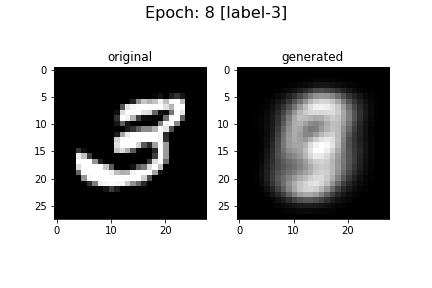

몇 번을 학습시켜도 위와 같은 이미지가 나오던 것인데, 
```python
rmse_loss = torch.sqrt(torch.mean(torch.square(target - x)) + 1e-7)
```
loss function을 위와 같이 짰을 때 계속해서 이런 현상이 나타났다.

다른 사람의 코드를 참고해서 BCE loss로 학습 시켜보니 정상적으로 학습이 되었는데, 처음에는 minibatch 내의 모든 loss를 label 상관 없이 학습 시킨 것이 문제가 되는 것으로 생각했다.

그래서 
```python
rmse_loss = torch.sqrt(torch.mean(torch.square(target - x), dim=-1) + 1e-7)
```
의 결과를 실험해보기도 했다.

그러나 이 경우 loss가 하나의 값으로 나오지 않아서 loss.backward() 부분에서 오류가 발생했다. 그렇다고 해서 bce에서 해준 것처럼 sum을 해준다면 앞선 것과 동일한 오류가 발생한다.

In [48]:
target = torch.rand(3,5)
x = torch.rand(3,5)
print(target)
print(x)
print('==========')
p = F.binary_cross_entropy(target=target, input = x, reduction='sum')
rmse_loss = torch.sqrt(torch.mean(torch.square(target - x)))
d = torch.sqrt(torch.nn.functional.mse_loss(x, target, reduction='mean'))

print(p)
print(rmse_loss)
print(d)


tensor([[0.1643, 0.2434, 0.3639, 0.8486, 0.9004],
        [0.4232, 0.3507, 0.4002, 0.5484, 0.6555],
        [0.2729, 0.6385, 0.1805, 0.4319, 0.3435]])
tensor([[0.9989, 0.2350, 0.2375, 0.2295, 0.2997],
        [0.5185, 0.9834, 0.5311, 0.4173, 0.9265],
        [0.7131, 0.6360, 0.9956, 0.4500, 0.3779]])
tensor(22.5487)
tensor(0.4346)
tensor(0.4346)


[torch.nn.functional 내에 있는 mse_loss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss)와 이론적으로 동일한 거라서 구현 문제는 아닌 것 같고, **왜 binary cross entropy만 먹힌 건지는 잘 모르겠다. 교재에 있는 건 root mean square error인데...**

In [10]:

# 진행상황 모니터링용
def compare_img(img, new_img, label, epoch):
  with torch.no_grad():
    if device == 'cuda': img, new_img = img.cpu(), new_img.cpu()
    show_original = img.view(28,28).numpy()
    show_gen = new_img.view(28,28).numpy()

    plt.subplot(1, 2, 1)
    plt.title('original')
    plt.imshow(show_original, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title('generated')
    plt.imshow(show_gen, cmap = 'gray')
    
    plt.suptitle('Epoch: {} [label-{}]'.format(epoch, label), fontsize=16)
    plt.savefig('MNIST_VAE_train_{}.png'.format(epoch))

    plt.clf() # 다음 그림 위해서 비워두기

In [11]:
optimizer = torch.optim.RMSprop(model.parameters(),lr = 0.001)

In [12]:
lenth = len(train_set)

In [50]:
epochs = 20
tick = [0, 5, 8, 10, 20, 50, 80, 100, 120, 150, 180, 200]

model.train(True)

for epoch in range(epochs):
  for idx, (img, label) in enumerate(train_set):
    img = img.to(device)
    
    new_img, mu, var = model(img)
    r, k, loss = loss_function(x= new_img, target = img, mu=mu, log_var=var)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (idx+1) % 500 is 0 : print('Epoch [{}/{}] Step [{}/{}] loss: {} rmse: {}, kl_div: {}'.format(epoch+1, epochs, idx+1, lenth, loss.item(), r.item(), k.item()))
  if epoch in tick : compare_img(img[0], new_img[0], label[0], epoch)
compare_img(img[0], new_img[0], label[0], epoch)

Epoch [1/20] Step [500/3000] loss: 3131.986083984375 rmse: 2937.93798828125, kl_div: 194.04798889160156
Epoch [1/20] Step [1000/3000] loss: 2990.840087890625 rmse: 2787.029296875, kl_div: 203.81080627441406
Epoch [1/20] Step [1500/3000] loss: 2858.624755859375 rmse: 2625.4677734375, kl_div: 233.15708923339844
Epoch [1/20] Step [2000/3000] loss: 2999.4892578125 rmse: 2731.283203125, kl_div: 268.2059326171875
Epoch [1/20] Step [2500/3000] loss: 2780.24560546875 rmse: 2515.784912109375, kl_div: 264.4606628417969
Epoch [1/20] Step [3000/3000] loss: 3225.636474609375 rmse: 2940.327392578125, kl_div: 285.30908203125
Epoch [2/20] Step [500/3000] loss: 3008.054931640625 rmse: 2745.6533203125, kl_div: 262.40167236328125
Epoch [2/20] Step [1000/3000] loss: 3532.03125 rmse: 3235.17919921875, kl_div: 296.8520812988281
Epoch [2/20] Step [1500/3000] loss: 3052.525634765625 rmse: 2790.1748046875, kl_div: 262.350830078125
Epoch [2/20] Step [2000/3000] loss: 2487.62646484375 rmse: 2243.2275390625, kl_d

<Figure size 432x288 with 0 Axes>

In [ ]:
compare_img(img[5], new_img[5], label[5], 78)

In [ ]:
target = torch.Tensor(23, 1, 28, 28)
target.view(-1, 784).shape

## 결과물


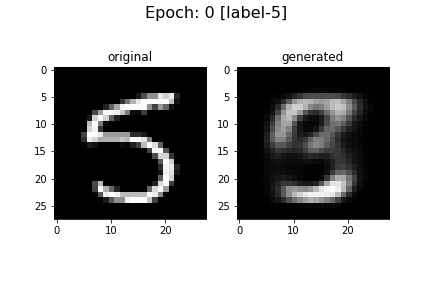

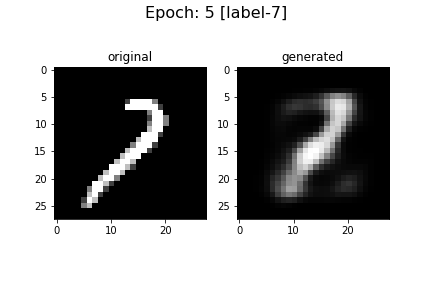

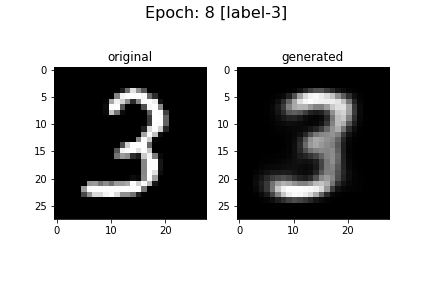

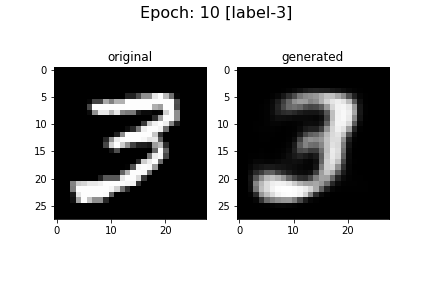

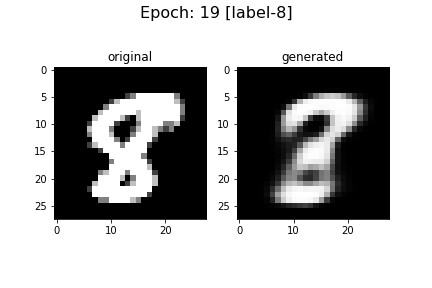